## Question - why is the Neural Network train and valid loss different?

In the FastAI notebook for tablular data [here](https://gist.github.com/lukebyrne/59e5deb8a80c30d9df955f4568f7651d) the rmse for `decision tree`, `random forest` and `neural network` are all in the same range.

When I run a similar process for data that I am loading in this notebook `decision tree` and `random forest` are in the same range, but `neural network` is different.

Can anyone suggest/tell me why?

## Load data

In [1]:
#%load_ext autotime
import pandas as pd
import numpy as np
import datetime

In [3]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [125]:
df = pd.read_pickle("for_github.pkl")

## Decision Tree

In [126]:
procs = [Categorify, FillMissing]

In [127]:
cond = 40000
train_idx = df[:cond].index
valid_idx = df[cond:].index

splits = (list(train_idx),list(valid_idx))

In [128]:
dep_var = "0"
#df[dep_var] = np.log(df[dep_var])

In [129]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [130]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [131]:
len(to.train), len(to.valid)

(40000, 9813)

In [132]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [133]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [134]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(6.317974, 7.623999)

## Random Forests

In [135]:
def rf(xs, y, n_estimators=40, max_samples=36855,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [136]:
m = rf(xs, y);

In [137]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(4.585376, 6.478981)

## Deep Learning

In [138]:
cont_nn, cat_nn = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [139]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [140]:
dls = to_nn.dataloaders(1024)

In [141]:
y = to_nn.train.y
y.min(),y.max()

(0.15, 100.0)

In [142]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=3.311311274956097e-06)

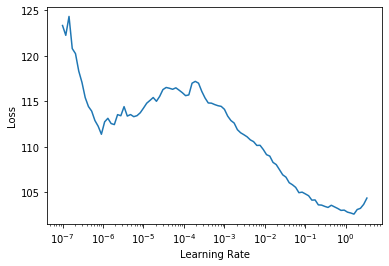

In [143]:
learn.lr_find()

In [144]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,time
0,102.871338,91.065262,00:04
1,97.540947,89.520782,00:04
2,95.404671,89.136551,00:04


In [145]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

9.441216